In [1]:
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sktime")

## functions

In [2]:
def plot_labels(X,y):
    label_0_indices = np.where(y == 0)[0]
    label_1_indices = np.where(y == 1)[0]

    # Select 5 cases from each label
    n_samples_to_plot = 5
    label_0_samples = label_0_indices[:n_samples_to_plot]
    label_1_samples = label_1_indices[:n_samples_to_plot]

    # Create a plot for both labels
    plt.figure(figsize=(10, 6))

    # Plot 5 cases from label 0
    for idx in label_0_samples:
        plt.plot(X[idx, 0, :], label=f"Label 0 - Sample {idx}", color='pink', alpha=0.6)

    # Plot 5 cases from label 1
    for idx in label_1_samples:
        plt.plot(X[idx, 0, :], label=f"Label 1 - Sample {idx}", color='olive', alpha=0.4)

    # Add legend and labels
    plt.title('5 Instances of Each Label')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.legend(loc="upper right")
    plt.tight_layout()

    # Show plot
plt.show()

In [3]:
def plot_incorrect_classifications(data_test, labels_test, y_pred, num_samples=10):
    """
    Plot incorrectly classified samples with true and predicted labels, colored by true label.

    Parameters:
    - data_test: The test dataset (3D array).
    - labels_test: True labels for the test dataset.
    - y_pred: Predicted labels for the test dataset.
    - num_samples: Number of incorrectly classified samples to plot.
    """
    # Identify incorrectly classified indices
    incorrect_indices = np.where(labels_test != y_pred)[0]

    # Limit to the specified number of incorrectly classified instances
    num_plots = min(num_samples, len(incorrect_indices))
    
    if num_plots == 0:
        print("No incorrectly classified samples to plot.")
        return

    # Create a color map for the labels
    unique_labels = np.unique(labels_test)
    colors = plt.cm.get_cmap('Set3', len(unique_labels))  # Use a colormap with distinct colors

    # Create a figure for the plot
    plt.figure(figsize=(10, 5))
    
    for i, index in enumerate(incorrect_indices[:num_plots]):
        # Get the color for the true label
        color = colors(labels_test[index])
        plt.plot(data_test[index].flatten(), label=f'True: {labels_test[index]}, Predicted: {y_pred[index]}', color=color)

    plt.title('Incorrectly Classified Samples')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.axhline(0, color='black', lw=0.5, ls='--')  # Add a horizontal line at y=0
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
def cutoff_SA(data, eye_index, start, sa_length, offset, no_sa):

    processed_eye = []

    for channel in data[eye_index]:

        # Initialize a list to store the processed data for the current channel
        processed_channel = []

        # Set the current index to start
        current_index = start

        for _ in range(no_sa):
            # Ensure we do not exceed the length of the data
            if current_index + sa_length > len(channel):
                break

            # Cut off the segment (remove 300 and jump 2700)
            processed_segment = channel[current_index+sa_length:current_index + offset]
            processed_channel = np.hstack((processed_channel,processed_segment))

            # Jump to the next position
            current_index += offset  # 300 + 2700 = 3000 total jump


        processed_eye.append(processed_channel)

    return processed_eye 

In [5]:
def conf_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Hivecote

In [6]:
data = np.load('/Users/marielunde/Desktop/Thesis/retinal-ecap-detection/mlp_spike_detection/simulated_data/X_no_spikes.npy')
labels = np.load('/Users/marielunde/Desktop/Thesis/retinal-ecap-detection/mlp_spike_detection/simulated_data/y_class_no_spikes.npy')

# Shuffle the data and create train-test split
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
data_train_3d = data_train[:, np.newaxis, :]  # Shape: (8000, 1, 200)
data_test_3d = data_test[:, np.newaxis, :]    # Shape: (2000, 1, 200)

# Convert labels to pandas Series
labels_train_series = pd.Series(labels_train)
labels_test_series = pd.Series(labels_test)



In [7]:
data2 = np.load('/Users/marielunde/Desktop/Thesis/retinal-ecap-detection/mlp_spike_detection/simulated_data/X_wn_level=10_no_means.npy')
labels2 = np.load('/Users/marielunde/Desktop/Thesis/retinal-ecap-detection/mlp_spike_detection/simulated_data/y_class_wn_level=10_no_means.npy')

# Shuffle the data and create train-test split
data_train2, data_test2, labels_train2, labels_test2 = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
data_train_3d2 = data_train2[:, np.newaxis, :]  # Shape: (8000, 1, 200)
data_test_3d2 = data_test2[:, np.newaxis, :]    # Shape: (2000, 1, 200)

# Convert labels to pandas Series
labels_train_series2 = pd.Series(labels_train2)
labels_test_series2 = pd.Series(labels_test2)



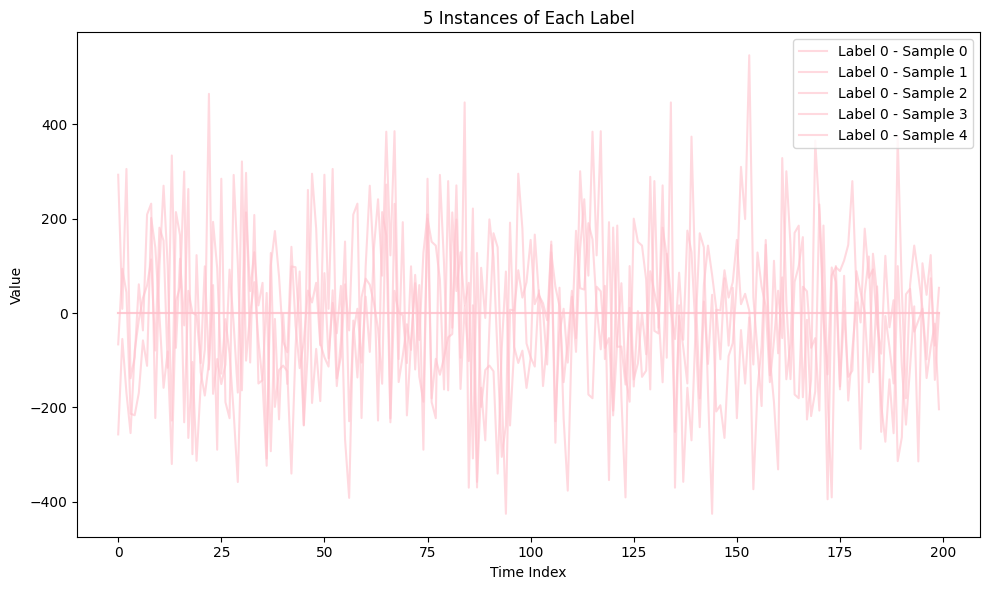

In [8]:
plot_labels(data_train_3d,labels_train)

In [9]:
classifier = HIVECOTEV2(time_limit_in_minutes=2,verbose=1)
classifier.fit(data_train_3d, labels_train_series)
# y_pred = classifier.predict(data_test_3d2)

# # Evaluate accuracy
# accuracy = accuracy_score(labels_test_series2, y_pred)
# print(f"Accuracy: {accuracy}")

Accuracy: 1.0


/Users/marielunde/Desktop/Thesis/venv_thesis/lib/python3.11/site-packages/sktime/base/_base_panel.py:575: UserWarning: only single label seen in y passed to fit of classifier HIVECOTEV2
  warn(


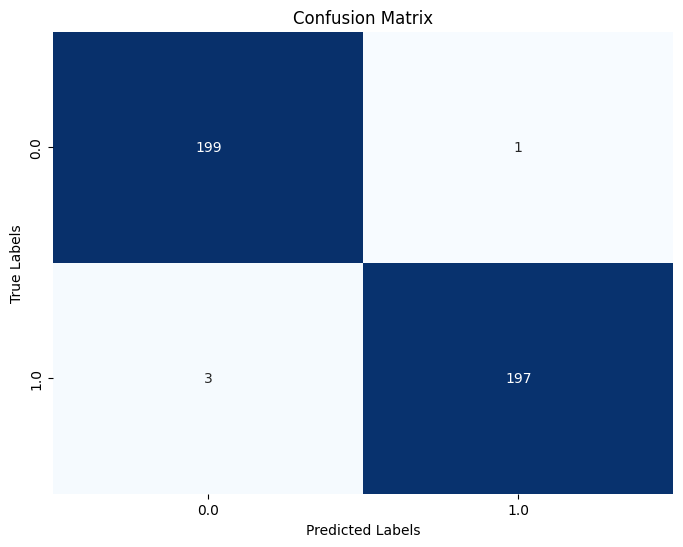

In [48]:
conf_matrix(labels_test, y_pred)

/var/folders/4r/ky8lg5_521vcwh4ltvn3c2300000gn/T/ipykernel_2764/879086309.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set3', len(unique_labels))  # Use a colormap with distinct colors


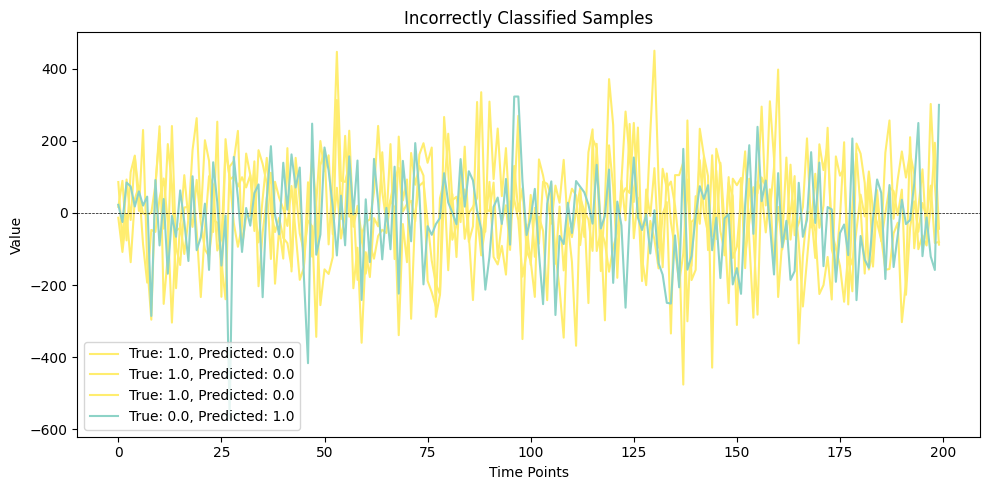

In [49]:
plot_incorrect_classifications(data_test_3d,labels_test,y_pred)

### Test of real data

In [28]:
import neo

In [29]:
### 3D data
# List of filenames for each eye
filenames_3D = [
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms003.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms002.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 4/10Hz_1V_neg500mV_1ms018.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 5/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 6/10Hz_1V_neg500mV_1ms011.ns5"
]

# Initialize an empty list to hold the data from all eyes
all_data_3D = []
filtered_data = []

# Parameters for the low-pass filter
fs = 30000  # Sampling frequency (Hz)
cutoff_frequency = 50  # Cutoff frequency for the low-pass filter (Hz)

# Loop through each file and read the data
for filename in filenames_3D:
    print(f"Reading data from file: {filename}")
    reader = neo.io.BlackrockIO(filename=filename)
    
    # Read the data from the file
    block_SA = reader.read_block()
    
    # Access the first segment
    segment_SA = block_SA.segments[0]
    
    # Access the first analog signal within this segment
    analog_signal_SA = segment_SA.analogsignals[0]
    
    # Access the signal data as a NumPy array and append it to the list
    data_SA = np.asarray(analog_signal_SA.magnitude)
    all_data_3D.append(data_SA)

all_data_3D = np.array(all_data_3D)
all_data_3D = np.transpose(all_data_3D, (0, 2, 1)) 
average_per_eye_3D = np.mean(all_data_3D, axis=1)
# Print shape of the data
print(f"Data shape: {np.shape(all_data_3D)}")
print(f"Data shape: {np.shape(average_per_eye_3D)}")

# List of filenames for each eye
filenames_3D_TTX = [
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms_TTX007.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms_TTX004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms_TTX007.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 4/10Hz_1V_neg500mV_1ms_TTX020.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 5/10Hz_1V_neg500mV_1ms_TTX005.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 6/10Hz_1V_neg500mV_1ms_TTX012.ns5"
]

# Initialize an empty list to hold the data from all eyes
all_data_3D_TTX = []
filtered_data_TTX = []

# Parameters for the low-pass filter
fs = 30000  # Sampling frequency (Hz)
cutoff_frequency = 50  # Cutoff frequency for the low-pass filter (Hz)

# Loop through each file and read the data
for filename in filenames_3D_TTX:
    print(f"Reading data from file: {filename}")
    reader = neo.io.BlackrockIO(filename=filename)
    
    # Read the data from the file
    block_SA = reader.read_block()
    
    # Access the first segment
    segment_SA = block_SA.segments[0]
    
    # Access the first analog signal within this segment
    analog_signal_SA = segment_SA.analogsignals[0]
    
    # Access the signal data as a NumPy array and append it to the list
    data_SA = np.asarray(analog_signal_SA.magnitude)
    all_data_3D_TTX.append(data_SA)

all_data_3D_TTX = np.array(all_data_3D_TTX)
all_data_3D_TTX = np.transpose(all_data_3D_TTX, (0, 2, 1)) 
average_per_eye_3D_TTX = np.mean(all_data_3D_TTX, axis=1)
# Print shape of the data
print(f"Data shape: {np.shape(all_data_3D_TTX)}")
print(f"Data shape: {np.shape(average_per_eye_3D_TTX)}")

Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms003.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms002.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms004.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 4/10Hz_1V_neg500mV_1ms018.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 5/10Hz_1V_neg500mV_1ms004.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 6/10Hz_1V_neg500mV_1ms011.ns5
Data shape: (6, 32, 300300)
Data shape: (6, 300300)
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms_TTX007.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms_TTX004.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms_TTX007.ns5
Reading d

In [30]:
processed_all_eyes_3D = [
    cutoff_SA(all_data_3D, eye_index=0, start=905, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=1, start=430, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=2, start=1850, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=3, start=480, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=4, start=2635, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=5, start=1455, sa_length=300, offset=3000, no_sa=100)
]

processed_all_eyes_3D_TTX = [
    cutoff_SA(all_data_3D_TTX, eye_index=0, start=1890, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=1, start=1765, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=2, start=2800, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=3, start=440, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=4, start=280, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=5, start=1380, sa_length=300, offset=3000, no_sa=100)
]


In [31]:
real_test_data = []
data = np.array(processed_all_eyes_3D_TTX[2][0])
random_numbers = np.random.randint(0, len(processed_all_eyes_3D_TTX[2][0]), 2000)
for idx in random_numbers:
    if idx + 200 <= len(data ):
        real_test_data.append(data [idx: idx + 200])
    
    if len(real_test_data) >= 2000:
        break

print(f"Collected {len(real_test_data)} real_test_data")

real_test_data_array = np.array(real_test_data)
real_test_data_array = real_test_data_array[:, np.newaxis, :] 

Collected 2000 real_test_data


In [32]:
y_pred = classifier.predict(real_test_data_array)

In [33]:
sum(y_pred)

1770.0

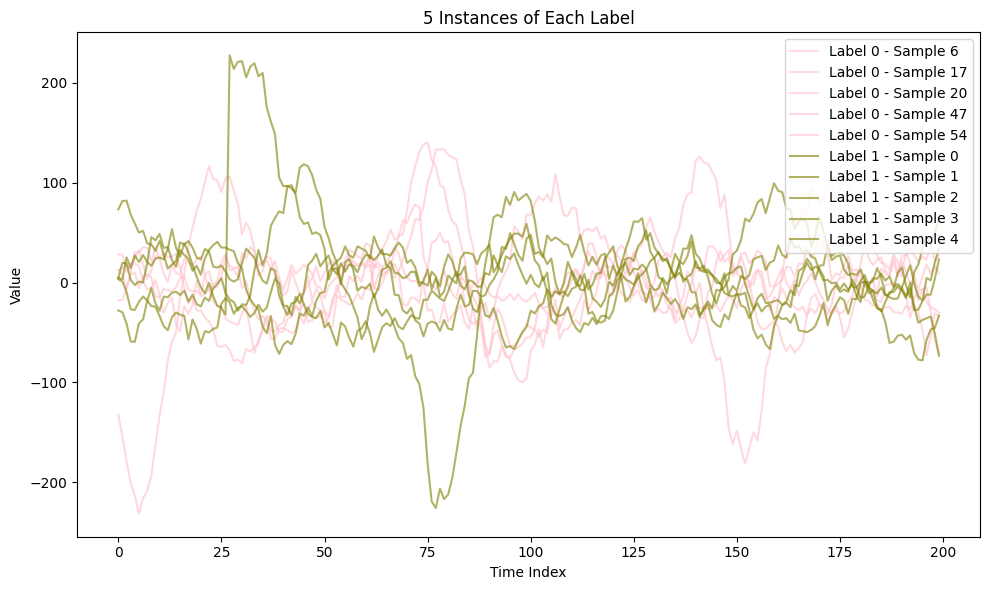

In [34]:
plot_labels(real_test_data_array,y_pred)